In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from collections import Counter
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor 


## CARGA DE DATOS Y PRIMERA VISIÓN DEL CONJUNTO

In [3]:
# Cargamos el dataset final de tintos. 

df = pd.read_csv("/Users/josetudela/Projects/vinos_grupo2/Proyecto_grupo2_vinos/FINAL_DF_TINTOS.csv")

In [4]:
#Info
df.shape

(20158, 20)

In [109]:
#Info
df.T.head

<bound method NDFrame.head of                                                                   0      \
Url                   https://www.vivino.com/ES/es/crealto-pionda/w/...   
ID                                                              3105259   
Nombre                                                           Pionda   
Año                                                                2018   
País                                                             Italia   
Región                                                       Monferrato   
Bodega                                                          Crealto   
Tipo de vino                                                 Vino tinto   
Uva                                                            Nebbiolo   
Precio                                                            32.53   
Valoración                                                          3.8   
Contenido de alcohol                                                  

## TRATAMIENTO DE DATOS PARA TENER EL DATASET LIMPIO Y CON LA ESTRUCTURA BUSCADA

In [110]:
# Modificamos maridaje porque contiene una "," en medio de la descrpción 

def limpiar_caza(texto):
    if isinstance(texto, str) and "caza" in texto.lower():  # Verifica si es texto y contiene "caza"
        return pd.Series(texto).replace(r"\s*\(.*?\)", "", regex=True).iloc[0]
    return texto  # Devuelve el texto sin cambios si no tiene "caza"

# Aplicar la limpieza a todas las celdas del DataFrame
df = df.applymap(limpiar_caza)

/var/folders/79/fd_qzfk141g8svblsrdwccqr0000gn/T/ipykernel_1525/211680032.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(limpiar_caza)


In [111]:
# Modificamos maridaje porque contiene una "," en medio de la descrpción 
def limpiar_pesca(texto):
    if isinstance(texto, str) and "azul " in texto.lower():  # Verifica si es texto y contiene "caza"
        return pd.Series(texto).replace(r"\s*\(.*?\)", "", regex=True).iloc[0]
    return texto  # Devuelve el texto sin cambios si no tiene "caza"

# Aplicar la limpieza a todas las celdas del DataFrame
df = df.applymap(limpiar_pesca)

/var/folders/79/fd_qzfk141g8svblsrdwccqr0000gn/T/ipykernel_1525/979100320.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(limpiar_pesca)


In [112]:
#Info
df.T

,0,1,2,3,4,5,6,7,8,9,...,20148,20149,20150,20151,20152,20153,20154,20155,20156,20157
Url,https://www.vivino.com/ES/es/crealto-pionda/w/...,https://www.vivino.com/ES/es/karpatska-perla-v...,https://www.vivino.com/ES/es/giachino-giac-pot...,https://www.vivino.com/ES/es/pelz-pinot-nero/w...,https://www.vivino.com/ES/es/finca-la-capilla-...,https://www.vivino.com/ES/es/suertes-del-marqu...,https://www.vivino.com/ES/es/attis-el-molinero...,https://www.vivino.com/ES/es/tenuta-ormanni-bo...,https://www.vivino.com/ES/es/alta-alella-orbus...,https://www.vivino.com/ES/es/chateau-combel-la...,...,https://www.vivino.com/ES/es/tommasi-le-prunee...,https://www.vivino.com/ES/es/milesi-poderi-le-...,https://www.vivino.com/ES/es/avgvstvs-cabernet...,https://www.vivino.com/ES/es/banfi-col-di-sass...,https://www.vivino.com/ES/es/covitoro-canus-ve...,https://www.vivino.com/ES/es/cantina-di-santad...,https://www.vivino.com/ES/es/es-nueva-crianza/...,https://www.vivino.com/ES/es/campestral-especi...,https://www.vivino.com/ES/es/portal-del-monsta...,https://www.vivino.com/ES/es/es-prohom-experie...
ID,3105259,1280319,6365197,2573275,1133110,5985946,6343332,1302561,2735037,3985319,...,7090,2608984,1692307,22913,1134541,17967,1210509,11571930,1437498,5731154
Nombre,Pionda,Varieto Frankovka Modrá,Giac' Potes,Pinot Nero,La Capilla Vendimia Seleccionada,Cruz Santa,El Molinero,Borro del Diavolo Riserva Chianti Classico,Orbus,Le Lac-aux-Cochons Cahors,...,Le Pruneé Merlot,Poderi le Cinte Curtefranca Rosso,Cabernet Sauvignon - Merlot,Col di Sasso (Cabernet Sauvignon - Sangiovese),Cañus Verus Viñas Viejas,Grotta Rossa Carignano del Sulcis,Crianza,Especial Tinto,Santes Negre Sustainable Vineyards,Prohom Experientia Negre
Año,2018,2021,2023,2020,2021,2020,2018,2021,2021,2021,...,2020,2022,2021,2022,2020,2022,2018,2020,No disponible,2021
País,Italia,Eslovaquia,Francia,Italia,España,España,España,Italia,España,Francia,...,Italia,Italia,España,Italia,España,Italia,España,España,España,España
Región,Monferrato,Malokarpatská,Savoie,Vigneti delle Dolomiti,Ribera del Duero,Valle de la Orotava,Rías Baixas,Chianti Classico,Alella,Cahors,...,delle Venezie,Curtefranca,Penedès,Toscana,Toro,Carignano del Sulcis,Rioja,Vino de España,Montsant,Terra Alta
Bodega,Crealto,Karpatská Perla,Domaine Giachino,Pelz,Finca La Capilla,Suertes del Marqués,Attis,Ormanni,Alta Alella,Château Combel La Serre,...,Tommasi,Milesi,Avgvstvs,Banfi,Covitoro,Santadi,Finca Nueva,Campestral,Portal del Montsant,Coma d'En Bonet
Tipo de vino,Vino tinto,Vino tinto,Vino tinto,Vino tinto,Vino tinto,Vino tinto,Vino tinto,Vino tinto,Vino tinto,Vino tinto,...,Vino tinto,Vino tinto,Vino tinto,Vino tinto,Vino tinto,Vino tinto,Vino tinto,Vino tinto,Vino tinto,Vino tinto
Uva,Nebbiolo,Blaufränkisch,"Gamay, Mondeuse Noire",Pinot Nero,Tinta del Pais,Vijariego Negro,Pinot Meunier,Sangiovese,Shiraz/Syrah,Malbec,...,Merlot,No disponible,"Cabernet Sauvignon, Merlot",Sangiovese,Tinta de toro,Carignan,Tempranillo,"Tintilla de Rota, Shiraz/Syrah, Cabernet Sauvi...",Ull de Llebre,"Shiraz/Syrah, Cabernet Sauvignon, Cariñena, Ga..."
Precio,32.53,32.52,32.52,32.50,32.50,32.50,32.50,32.50,32.50,32.50,...,10.88,10.88,10.88,10.86,9,12.40,10.85,10.85,8.51,10.85


In [113]:
#info
df.dtypes

Url                     object
ID                      object
Nombre                  object
Año                     object
País                    object
Región                  object
Bodega                  object
Tipo de vino            object
Uva                     object
Precio                  object
Valoración              object
Contenido de alcohol    object
Maridajes               object
Ligero/Poderoso         object
Suave/Tánico            object
Seco/Dulce              object
Débil/Ácido             object
Taste_Note_1            object
Taste_Note_2            object
Taste_Note_3            object
dtype: object

In [114]:
#Separamos la columna maridajes para que cada una sea una característica
df_maridaje_separado =  df["Maridajes"].str.split(',', expand=True)
df_maridaje_separado["ID"]= df["ID"]
df_maridaje_separado = df_maridaje_separado.fillna("Desconocido")
df_maridaje_separado[100:140]

,0,1,2,3,4,5,ID
100,Ternera,Cordero,Carne de caza,Desconocido,Desconocido,Desconocido,1181447
101,Ternera,Cordero,Pasta,Desconocido,Desconocido,Desconocido,1123194
102,Ternera,Cordero,Ternera lechal,Aves,Carne adobada,Desconocido,1420652
103,Ternera,Cordero,Aves,Pasta,Desconocido,Desconocido,2475833
104,Ternera,Cordero,Aves,Carne de caza,Desconocido,Desconocido,79640
105,Ternera lechal,Cerdo,Aves,Pasta,Carne de caza,Desconocido,1101307
106,Ternera,Cordero,Pasta,Carne de caza,Desconocido,Desconocido,1150701
107,Ternera lechal,Cerdo,Aves,Pasta,Carne de caza,Desconocido,1211200
108,Ternera,Cordero,Pasta,Carne de caza,Desconocido,Desconocido,1546843
109,Ternera,Ternera lechal,Aves,Carne de caza,Desconocido,Desconocido,2620585


In [115]:
# vemos los valores únicos para poder hacer one hot encoding. 
valores_unicos_maridaje = set(df_maridaje_separado.drop(columns=["ID"]).values.ravel())
print(valores_unicos_maridaje)

{'Ternera lechal', ' Cordero', 'Cordero', ' Carne adobada', ' Ternera lechal', ' Queso azul', ' Champiñones', ' Aves', ' Carne de caza', ' Aperitivos y tentempiés', ' Queso curado', 'Cerdo', 'Maridajes', ' Pasta', ' Queso tierno y cremoso', 'Carne de caza', ' La comida basura vale', ' Queso de leche de cabra', ' Pescado blanco', ' Comida picante', ' Cerdo', ' Vegetariana', 'No disponible', 'Ternera', 'Desconocido', 'Aves', 'Pasta', ' Pescado azul'}


In [116]:
#Info
len(valores_unicos_maridaje)

28

In [117]:
df_maridaje_separado_sin_ID = df_maridaje_separado.drop(columns = "ID")

In [118]:
pd.get_dummies(df_maridaje_separado_sin_ID[[0,1]], prefix='', prefix_sep='')

,Aves,Carne de caza,Cerdo,Cordero,Maridajes,No disponible,Pasta,Ternera,Ternera lechal,Aperitivos y tentempiés,Aves,Carne adobada,Carne de caza,Cerdo,Cordero,Queso curado,Ternera lechal,Vegetariana,Desconocido
0,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False
1,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False
2,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False
3,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20153,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False
20154,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False
20155,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False
20156,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False


In [119]:
df_maridaje_separado_sin_ID = df_maridaje_separado.drop(columns=["ID"])

df_maridaje_separado_sin_ID = df_maridaje_separado_sin_ID.applymap(lambda x: x.replace(" ", "") if isinstance(x, str) else x)
# Convertir todo el DataFrame a One-Hot Encoding sin prefijos por columna
df_maridaje_separado_sin_ID_encoded = pd.get_dummies(df_maridaje_separado_sin_ID,drop_first=True ,prefix="" ,prefix_sep="")

# Convertir a DataFrame
df_maridaje_separado_sin_ID_encoded = pd.DataFrame(df_maridaje_separado_sin_ID_encoded)

# Mostrar resultado
display(df_maridaje_separado_sin_ID_encoded)

/var/folders/79/fd_qzfk141g8svblsrdwccqr0000gn/T/ipykernel_1525/3108444008.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_maridaje_separado_sin_ID = df_maridaje_separado_sin_ID.applymap(lambda x: x.replace(" ", "") if isinstance(x, str) else x)


,Carnedecaza,Cerdo,Cordero,Maridajes,Nodisponible,Pasta,Ternera,Terneralechal,Aves,Carneadobada,...,Champiñones,Comidapicante,Desconocido,Lacomidabasuravale,Quesocurado,Quesodelechedecabra,Quesotiernoycremoso,Desconocido,Quesoazul,Quesodelechedecabra
0,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,True,False,False
1,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,True,False,False
2,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,True,False,False
3,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,True,False,False
4,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20153,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,True,False,False
20154,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,True,False,False
20155,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,True,False,False
20156,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,True,False,False


In [120]:
df_maridaje_separado_sin_ID_encoded.columns.nunique()

21

In [121]:
df_maridaje_separado_sin_ID_encoded=df_maridaje_separado_sin_ID_encoded.groupby(axis=1, level=0).sum()
df_maridaje_separado_encoded = df_maridaje_separado_sin_ID_encoded
df_maridaje_separado_encoded["ID"] = df["ID"]
df_maridaje_separado_encoded

/var/folders/79/fd_qzfk141g8svblsrdwccqr0000gn/T/ipykernel_1525/1026340629.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_maridaje_separado_sin_ID_encoded=df_maridaje_separado_sin_ID_encoded.groupby(axis=1, level=0).sum()


,Aves,Carneadobada,Carnedecaza,Cerdo,Champiñones,Comidapicante,Cordero,Desconocido,Lacomidabasuravale,Maridajes,...,Pescadoazul,Pescadoblanco,Quesoazul,Quesocurado,Quesodelechedecabra,Quesotiernoycremoso,Ternera,Terneralechal,Vegetariana,ID
0,0,0,1,0,0,0,1,2,0,0,...,0,0,0,0,0,0,1,0,0,3105259
1,0,0,1,0,0,0,1,2,0,0,...,0,0,0,0,0,0,1,0,0,1280319
2,0,0,1,0,0,0,0,2,0,0,...,0,0,0,1,0,1,1,0,0,6365197
3,0,0,1,0,0,0,0,2,0,0,...,0,0,0,0,0,0,1,1,0,2573275
4,0,0,1,0,0,0,1,3,0,0,...,0,0,0,0,0,0,1,0,0,1133110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20153,0,0,0,0,0,0,1,3,0,0,...,0,0,0,0,0,0,1,0,0,17967
20154,1,0,0,0,0,0,1,2,0,0,...,0,0,0,0,0,0,1,1,0,1210509
20155,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,1,1,0,11571930
20156,0,0,0,0,0,0,1,3,0,0,...,0,0,0,0,0,0,1,0,0,1437498


In [122]:
#Separamos las notas de sabor en columnas diferentes. 

df_taste_1_separado = df["Taste_Note_1"].str.split(',', expand=True)
df_taste_1_separado


,0,1,2
0,Terroso,cuero,virutas...
1,cereza,frutos rojos,None
2,fresa,frambuesa,cerez...
3,No disponible,None,None
4,ciruela,fruta negra,c...
...,...,...,...
20153,Terroso,cuero,humo
20154,roble,vainilla,tabaco
20155,No disponible,None,None
20156,fruta negra,mora,arán...


In [123]:
#Separamos las notas de sabor en columnas diferentes. 

df_taste_2_separado = df["Taste_Note_2"].str.split(',', expand=True)
df_taste_2_separado

,0,1,2
0,fresa,cereza,arándano...
1,Terroso,piedra,None
2,casis,mora,fruta negr...
3,No disponible,None,None
4,roble,vainilla,tabaco
...,...,...,...
20153,cereza,frutos rojos,f...
20154,cereza,frutos rojos,c...
20155,No disponible,None,None
20156,cereza,frambuesa,fres...


In [124]:
#Separamos las notas de sabor en columnas diferentes. 

df_taste_3_separado = df["Taste_Note_3"].str.split(',', expand=True)
df_taste_3_separado

,0,1,2
0,frutos del bosque,merm...,None
1,chocolate,tabaco,vain...
2,Terroso,minerales,cue...
3,No disponible,None,None
4,cuero,Terroso,ceniza
...,...,...,...
20153,roble,chocolate,tabac...
20154,mora,cereza negra,cir...
20155,No disponible,None,None
20156,Terroso,carne a la par...,None


In [125]:
#Método "casero" para unir todas la notas de sabor separadas en un solo df
df_taste_1_separado[3] = df_taste_2_separado[0]
df_taste_1_separado[4] = df_taste_2_separado[1]
df_taste_1_separado[5] = df_taste_2_separado[2]
df_taste_1_separado[6] = df_taste_3_separado[0]
df_taste_1_separado[7] = df_taste_3_separado[1]
df_taste_1_separado[8] = df_taste_3_separado[2]
df_taste_1_separado["ID"] = df["ID"]
df_taste_1_separado


,0,1,2,3,4,5,6,7,8,ID
0,Terroso,cuero,virutas...,fresa,cereza,arándano...,frutos del bosque,merm...,None,3105259
1,cereza,frutos rojos,None,Terroso,piedra,None,chocolate,tabaco,vain...,1280319
2,fresa,frambuesa,cerez...,casis,mora,fruta negr...,Terroso,minerales,cue...,6365197
3,No disponible,None,None,No disponible,None,None,No disponible,None,None,2573275
4,ciruela,fruta negra,c...,roble,vainilla,tabaco,cuero,Terroso,ceniza,1133110
...,...,...,...,...,...,...,...,...,...,...
20153,Terroso,cuero,humo,cereza,frutos rojos,f...,roble,chocolate,tabac...,17967
20154,roble,vainilla,tabaco,cereza,frutos rojos,c...,mora,cereza negra,cir...,1210509
20155,No disponible,None,None,No disponible,None,None,No disponible,None,None,11571930
20156,fruta negra,mora,arán...,cereza,frambuesa,fres...,Terroso,carne a la par...,None,1437498


In [126]:
df_taste_1_separado[:1000].to_csv("df_taste_1_separado_0_1000.csv", index= False)

In [127]:
df_taste_1_separado_tijera = df_taste_1_separado.applymap(lambda x: None if isinstance(x, str) and x.endswith('.') else x)
df_taste_1_separado_tijera

/var/folders/79/fd_qzfk141g8svblsrdwccqr0000gn/T/ipykernel_1525/2875308546.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_taste_1_separado_tijera = df_taste_1_separado.applymap(lambda x: None if isinstance(x, str) and x.endswith('.') else x)


,0,1,2,3,4,5,6,7,8,ID
0,Terroso,cuero,None,fresa,cereza,None,frutos del bosque,None,None,3105259
1,cereza,frutos rojos,None,Terroso,piedra,None,chocolate,tabaco,None,1280319
2,fresa,frambuesa,None,casis,mora,None,Terroso,minerales,None,6365197
3,No disponible,None,None,No disponible,None,None,No disponible,None,None,2573275
4,ciruela,fruta negra,None,roble,vainilla,tabaco,cuero,Terroso,ceniza,1133110
...,...,...,...,...,...,...,...,...,...,...
20153,Terroso,cuero,humo,cereza,frutos rojos,None,roble,chocolate,None,17967
20154,roble,vainilla,tabaco,cereza,frutos rojos,None,mora,cereza negra,None,1210509
20155,No disponible,None,None,No disponible,None,None,No disponible,None,None,11571930
20156,fruta negra,mora,None,cereza,frambuesa,None,Terroso,None,None,1437498


In [128]:
df_taste_1_separado_tijera_sin_ID = df_taste_1_separado_tijera.drop(columns="ID")

In [129]:
valores_unicos_taste =set(df_taste_1_separado_tijera_sin_ID.values.ravel())
print(valores_unicos_taste)

{'piel de naranja', ' tiza', ' canela', 'tomillo', 'hoja de tabaco', 'mermelada de mora', ' chocolate amargo', ' fruta seca', 'minerales', 'piedra', ' hoja de tabaco', 'zarza', ' matcha', 'azúcar morena', ' petróleo', ' ajedrea', 'queso', ' jalapeño', 'mejorana', 'levadura de cerveza', ' virutas de lápiz', 'cera de abejas', 'cacao', 'sabor a nuez', ' paja', ' mantequilla', 'pimiento rojo', ' mora madura', ' eneldo', 'hoja de tomate', 'limón', ' pan integral', ' romero seco', 'cáscara de naranja', ' lirio', ' fresa salvaje', ' sandía', ' fresa', ' olla de barro', ' cacao', 'melaza', ' rosa seca', ' ciruela', 'algodón de azúcar', ' mejorana', ' masa madre', ' tabaco dulce', 'tabaco de mascar', ' acacia', 'iris', 'grosella espinosa', ' hoja de tomate', 'frambuesa negra', ' piedra', ' arándano rojo', 'regaliz', 'salsa de bayas', ' açaí', 'gravilla triturada', 'piña verde', 'cilantro', 'tabaco dulce', ' tarta de fruta', 'romero seco', 'tabaco para pipa', ' carnes ahumadas', ' anís', ' queso

In [130]:

# Convertir todo el DataFrame a One-Hot Encoding sin prefijos por columna
df_taste_1_one_hot_encoded = pd.get_dummies(df_taste_1_separado_tijera_sin_ID, prefix='', prefix_sep='')

# Convertir a DataFrame
df_taste_1_one_hot_encoded = pd.DataFrame(df_taste_1_one_hot_encoded)

df

# Mostrar resultado
display(df_taste_1_one_hot_encoded)

,Carne adobada,Carne de caza,No disponible,Polvo de 5 especias,Terroso,aceite,aceituna negra,aceto balsámico,agua de rosas,ajedrea,...,sándalo,sílex,tabaco,tiza,tofi,tomate,tomillo,vainilla,yogur,zarza
0,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20153,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
20154,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
20155,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
20156,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [131]:
df_taste_1_one_hot_encoded=df_taste_1_one_hot_encoded.groupby(axis=1, level=0).sum()
df_taste_1_one_hot_encoded

/var/folders/79/fd_qzfk141g8svblsrdwccqr0000gn/T/ipykernel_1525/770153049.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_taste_1_one_hot_encoded=df_taste_1_one_hot_encoded.groupby(axis=1, level=0).sum()


,Carne adobada,Carne de caza,Terroso,acacia,aceite,aceite de coco,aceituna negra,acelga,aceto balsámico,agua de rosas,...,tostada,tropical,trufa negra,té Earl Grey,té Oolong,vainilla,violeta,virutas de lápiz,yogur,zarza
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20153,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20154,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20155,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20156,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [132]:
conteo_valores_unicos_taste = df_taste_1_one_hot_encoded.sum()

In [133]:
conteo_valores_unicos_taste

 Carne adobada        27
 Carne de caza        66
 Terroso            4964
 acacia                3
 aceite               14
                    ... 
vainilla            1386
violeta              113
virutas de lápiz       8
yogur                  6
zarza                 23
Length: 503, dtype: int64

In [134]:
df_taste_1_one_hot_encoded["ID"] = df["ID"]

In [135]:
a = 15  # Define el valor de 'a'

conteo_valores_unicos_taste_serie = [(conteo_valores_unicos_taste > i).sum() for i in range(a)]

conteo_valores_unicos_taste_serie

[np.int64(503),
 np.int64(413),
 np.int64(367),
 np.int64(330),
 np.int64(295),
 np.int64(274),
 np.int64(261),
 np.int64(245),
 np.int64(232),
 np.int64(226),
 np.int64(217),
 np.int64(210),
 np.int64(201),
 np.int64(197),
 np.int64(193)]

In [136]:
mayor_que = list(range(0,a))
mayor_que

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

Text(0.5, 1.0, 'palabras unicas vs filtro por > que')

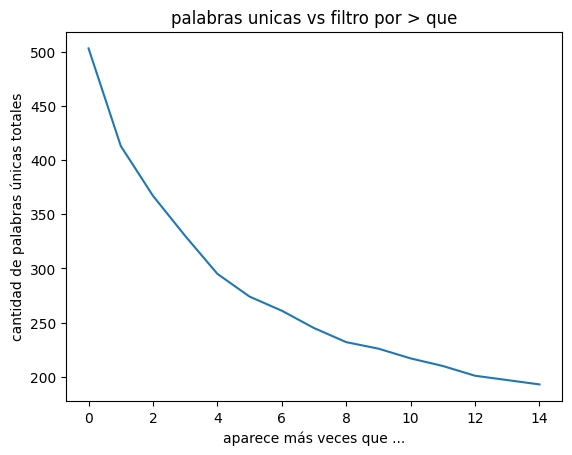

In [137]:
#Gráfico para apoyarnos si queremos eliminar palabras únicas que se repitan poco

plt.plot(mayor_que,conteo_valores_unicos_taste_serie,)
plt.xlabel('aparece más veces que ...')
plt.ylabel('cantidad de palabras únicas totales')
plt.title('palabras unicas vs filtro por > que')

In [138]:
df_merged_one_hot = pd.concat([df.set_index("ID"), df_maridaje_separado_encoded.set_index("ID"), df_taste_1_one_hot_encoded.set_index("ID")], axis=1).reset_index()

display(df_merged_one_hot.head())

,ID,Url,Nombre,Año,País,Región,Bodega,Tipo de vino,Uva,Precio,...,tostada,tropical,trufa negra,té Earl Grey,té Oolong,vainilla,violeta,virutas de lápiz,yogur,zarza
0,3105259,https://www.vivino.com/ES/es/crealto-pionda/w/...,Pionda,2018,Italia,Monferrato,Crealto,Vino tinto,Nebbiolo,32.53,...,0,0,0,0,0,0,0,0,0,0
1,1280319,https://www.vivino.com/ES/es/karpatska-perla-v...,Varieto Frankovka Modrá,2021,Eslovaquia,Malokarpatská,Karpatská Perla,Vino tinto,Blaufränkisch,32.52,...,0,0,0,0,0,0,0,0,0,0
2,6365197,https://www.vivino.com/ES/es/giachino-giac-pot...,Giac' Potes,2023,Francia,Savoie,Domaine Giachino,Vino tinto,"Gamay, Mondeuse Noire",32.52,...,0,0,0,0,0,0,0,0,0,0
3,2573275,https://www.vivino.com/ES/es/pelz-pinot-nero/w...,Pinot Nero,2020,Italia,Vigneti delle Dolomiti,Pelz,Vino tinto,Pinot Nero,32.50,...,0,0,0,0,0,0,0,0,0,0
4,1133110,https://www.vivino.com/ES/es/finca-la-capilla-...,La Capilla Vendimia Seleccionada,2021,España,Ribera del Duero,Finca La Capilla,Vino tinto,Tinta del Pais,32.50,...,0,0,0,0,0,0,0,0,0,0


In [139]:
df_merged_one_hot=df_merged_one_hot.drop(index=5264)

In [140]:
df_merged_one_hot["ID"] = df_merged_one_hot["ID"].astype(int)

In [141]:
df_merged_one_hot = df_merged_one_hot.drop(columns=["Tipo de vino","Url"])

In [142]:
df_merged_one_hot[["Nombre","País","Región","Bodega","Uva"]] = df_merged_one_hot[["Nombre","País","Región","Bodega","Uva"]].astype(str)

In [143]:
df_merged_one_hot

,ID,Nombre,Año,País,Región,Bodega,Uva,Precio,Valoración,Contenido de alcohol,...,tostada,tropical,trufa negra,té Earl Grey,té Oolong,vainilla,violeta,virutas de lápiz,yogur,zarza
0,3105259,Pionda,2018,Italia,Monferrato,Crealto,Nebbiolo,32.53,3.8,5,...,0,0,0,0,0,0,0,0,0,0
1,1280319,Varieto Frankovka Modrá,2021,Eslovaquia,Malokarpatská,Karpatská Perla,Blaufränkisch,32.52,3.5,13,...,0,0,0,0,0,0,0,0,0,0
2,6365197,Giac' Potes,2023,Francia,Savoie,Domaine Giachino,"Gamay, Mondeuse Noire",32.52,3.8,No disponible,...,0,0,0,0,0,0,0,0,0,0
3,2573275,Pinot Nero,2020,Italia,Vigneti delle Dolomiti,Pelz,Pinot Nero,32.50,3.8,No disponible,...,0,0,0,0,0,0,0,0,0,0
4,1133110,La Capilla Vendimia Seleccionada,2021,España,Ribera del Duero,Finca La Capilla,Tinta del Pais,32.50,4.3,15,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20153,17967,Grotta Rossa Carignano del Sulcis,2022,Italia,Carignano del Sulcis,Santadi,Carignan,12.40,3.6,14,...,0,0,0,0,0,0,0,0,0,0
20154,1210509,Crianza,2018,España,Rioja,Finca Nueva,Tempranillo,10.85,3.7,13,...,0,0,0,0,0,0,0,0,0,0
20155,11571930,Especial Tinto,2020,España,Vino de España,Campestral,"Tintilla de Rota, Shiraz/Syrah, Cabernet Sauvi...",10.85,3.7,13,...,0,0,0,0,0,0,0,0,0,0
20156,1437498,Santes Negre Sustainable Vineyards,No disponible,España,Montsant,Portal del Montsant,Ull de Llebre,8.51,3.5,5,...,0,0,0,0,0,0,0,0,0,0


In [144]:
len(set(df_merged_one_hot["Bodega"]))

7781

In [145]:
df_merged_one_hot_droped= df_merged_one_hot.drop(columns=["Año","Nombre","Maridajes","Taste_Note_1","Taste_Note_2","Taste_Note_3"])

In [146]:
df_merged_one_hot_droped["Valoración"] = pd.to_numeric(df_merged_one_hot["Valoración"], errors='coerce')
df_merged_one_hot_droped["Contenido de alcohol"] = pd.to_numeric(df_merged_one_hot["Contenido de alcohol"], errors='coerce')
df_merged_one_hot_droped["Ligero/Poderoso"] = pd.to_numeric(df_merged_one_hot["Ligero/Poderoso"], errors='coerce')
df_merged_one_hot_droped["Suave/Tánico"] = pd.to_numeric(df_merged_one_hot["Suave/Tánico"], errors='coerce')
df_merged_one_hot_droped["Seco/Dulce"] = pd.to_numeric(df_merged_one_hot["Seco/Dulce"], errors='coerce')
df_merged_one_hot_droped["Débil/Ácido"] = pd.to_numeric(df_merged_one_hot["Débil/Ácido"], errors='coerce')
df_merged_one_hot_droped["Precio"] = pd.to_numeric(df_merged_one_hot["Precio"], errors='coerce')




In [147]:
df_merged_one_hot_droped[df_merged_one_hot_droped["Valoración"].isna()]

,ID,País,Región,Bodega,Uva,Precio,Valoración,Contenido de alcohol,Ligero/Poderoso,Suave/Tánico,...,tostada,tropical,trufa negra,té Earl Grey,té Oolong,vainilla,violeta,virutas de lápiz,yogur,zarza
17564,9417833,No disponible,No disponible,No disponible,No disponible,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [148]:
df_merged_one_hot_droped = df_merged_one_hot_droped.drop(index=17564)

In [149]:
df_merged_one_hot_droped = df_merged_one_hot_droped.drop(columns="No disponible")

In [150]:
X= df_merged_one_hot_droped.drop(columns="Valoración")
y = df_merged_one_hot_droped["Valoración"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [151]:


'''import pandas as pd

# Suponiendo que ya tienes los conjuntos X_train, X_test, y_train

# 1. Calcular la media de la variable objetivo 'Valoración' en y_train por cada categoría en 'Bodega' (de X_train)
mean_encoding_bodega = y_train.groupby(X_train['Bodega']).mean()

# 2. Reemplazar las categorías en 'Bodega' con la media calculada en y_train
X_train['Bodega_encoded'] = X_train['Bodega'].map(mean_encoding_bodega)

# 3. Para el conjunto de prueba, debes usar la media calculada en el conjunto de entrenamiento
X_test['Bodega_encoded'] = X_test['Bodega'].map(mean_encoding_bodega)

# Ahora puedes usar 'Bodega_encoded' en X_train y X_test para entrenar el modelo

mean_encoding_pais = y_train.groupby(X_train['País']).mean()

# 2. Reemplazar las categorías en 'Bodega' con la media calculada en y_train
X_train['País_encoded'] = X_train['País'].map(mean_encoding_pais)

# 3. Para el conjunto de prueba, debes usar la media calculada en el conjunto de entrenamiento
X_test['País_encoded'] = X_test['País'].map(mean_encoding_pais)



mean_encoding_region = y_train.groupby(X_train['Región']).mean()

# 2. Reemplazar las categorías en 'Bodega' con la media calculada en y_train
X_train['Región_encoded'] = X_train['Región'].map(mean_encoding_region)

# 3. Para el conjunto de prueba, debes usar la media calculada en el conjunto de entrenamiento
X_test['Región_encoded'] = X_test['Región'].map(mean_encoding_region)

mean_encoding_bodega = y_train.groupby(X_train['Uva']).mean()

# 2. Reemplazar las categorías en 'Bodega' con la media calculada en y_train
X_train['Uva_encoded'] = X_train['Uva'].map(mean_encoding_bodega)

# 3. Para el conjunto de prueba, debes usar la media calculada en el conjunto de entrenamiento
X_test['Uva_encoded'] = X_test['Uva'].map(mean_encoding_bodega)

X_train = X_train.drop(columns=["País","Región","Bodega","Uva"])
X_test = X_test.drop(columns=["País","Región","Bodega","Uva"])'''



'import pandas as pd\n\n# Suponiendo que ya tienes los conjuntos X_train, X_test, y_train\n\n# 1. Calcular la media de la variable objetivo \'Valoración\' en y_train por cada categoría en \'Bodega\' (de X_train)\nmean_encoding_bodega = y_train.groupby(X_train[\'Bodega\']).mean()\n\n# 2. Reemplazar las categorías en \'Bodega\' con la media calculada en y_train\nX_train[\'Bodega_encoded\'] = X_train[\'Bodega\'].map(mean_encoding_bodega)\n\n# 3. Para el conjunto de prueba, debes usar la media calculada en el conjunto de entrenamiento\nX_test[\'Bodega_encoded\'] = X_test[\'Bodega\'].map(mean_encoding_bodega)\n\n# Ahora puedes usar \'Bodega_encoded\' en X_train y X_test para entrenar el modelo\n\nmean_encoding_pais = y_train.groupby(X_train[\'País\']).mean()\n\n# 2. Reemplazar las categorías en \'Bodega\' con la media calculada en y_train\nX_train[\'País_encoded\'] = X_train[\'País\'].map(mean_encoding_pais)\n\n# 3. Para el conjunto de prueba, debes usar la media calculada en el conjunto de

In [152]:
import pandas as pd

def mean_encode_smoothing(train_col, y_train, test_col, alpha=10):
    """
    Aplica Mean Encoding con Smoothing a una columna categórica.
    
    train_col: pd.Series con la columna categórica de entrenamiento.
    y_train: pd.Series con la variable objetivo de entrenamiento.
    test_col: pd.Series con la columna categórica de test.
    alpha: Factor de suavizado, valores más altos suavizan más.
    
    Devuelve: Columnas transformadas para entrenamiento y test.
    """
    mean_global = y_train.mean()  # Media global de la variable objetivo
    category_stats = y_train.groupby(train_col).agg(['mean', 'count'])  # Media y frecuencia por categoría
    category_stats['smooth'] = (category_stats['mean'] * category_stats['count'] + mean_global * alpha) / (category_stats['count'] + alpha)
    
    # Aplicamos la transformación a train y test
    train_encoded = train_col.map(category_stats['smooth'])
    test_encoded = test_col.map(category_stats['smooth']).fillna(mean_global)  # Fillna para valores no vistos
    
    return train_encoded, test_encoded

# Aplicamos la función a cada variable categórica
X_train['Bodega_encoded'], X_test['Bodega_encoded'] = mean_encode_smoothing(X_train['Bodega'], y_train, X_test['Bodega'])
X_train['País_encoded'], X_test['País_encoded'] = mean_encode_smoothing(X_train['País'], y_train, X_test['País'])
X_train['Región_encoded'], X_test['Región_encoded'] = mean_encode_smoothing(X_train['Región'], y_train, X_test['Región'])
X_train['Uva_encoded'], X_test['Uva_encoded'] = mean_encode_smoothing(X_train['Uva'], y_train, X_test['Uva'])

# Eliminamos las columnas originales
X_train.drop(columns=["País", "Región", "Bodega", "Uva"], inplace=True)
X_test.drop(columns=["País", "Región", "Bodega", "Uva"], inplace=True)

In [153]:
X_train

,ID,Precio,Contenido de alcohol,Ligero/Poderoso,Suave/Tánico,Seco/Dulce,Débil/Ácido,Aves,Carneadobada,Carnedecaza,...,té Oolong,vainilla,violeta,virutas de lápiz,yogur,zarza,Bodega_encoded,País_encoded,Región_encoded,Uva_encoded
17865,1128968,360.00,13.0,4.7,3.5,1.2,7.4,0,0,1,...,0,0,0,0,0,0,4.091467,3.993496,4.015772,4.073684
6718,1478235,13.48,NaN,8.2,4.9,1.5,5.6,0,0,1,...,0,0,0,0,0,0,3.943400,3.860383,4.112247,3.910067
2394,3146052,4.48,5.0,5.5,3.4,1.6,4.1,0,0,0,...,0,0,0,0,0,0,3.847754,3.860383,3.644701,3.727082
459,6181943,42.50,5.0,2.0,2.2,0.1,7.4,0,0,1,...,0,0,0,0,0,0,3.947346,3.880002,3.826174,4.073684
14616,1169092,41.50,13.0,4.8,5.7,0.8,6.3,0,0,1,...,0,0,0,0,0,0,3.951733,3.953857,4.253210,4.014125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11285,5014272,46.55,NaN,2.3,2.4,1.1,6.6,0,0,1,...,0,0,0,0,0,0,3.955446,4.037052,4.075371,4.073684
11965,2945399,18.50,5.0,8.5,5.1,1.3,5.4,0,0,1,...,0,0,0,0,0,0,3.976733,3.860383,4.112247,3.956436
5391,2287923,58.90,5.0,5.9,6.8,0.5,8.4,0,0,1,...,0,0,0,0,0,0,4.080832,3.953857,4.122070,4.084555
860,9876372,16.30,5.0,6.1,3.7,0.0,3.7,0,0,0,...,0,0,0,0,0,0,3.929164,3.860383,3.762443,3.929164


In [154]:
X_train_precio_no_disponible = X_train[X_train["Precio"]=="No disponible"].index
X_train_alcohol_no_disponible = X_train[X_train["Contenido de alcohol"]=="No disponible"].index
X_test_precio_no_disponible = X_test[X_test["Precio"]=="No disponible"].index
X_test_alcohol_no_dispobible = X_test[X_test["Contenido de alcohol"]=="No disponible"].index

In [155]:
X_train["Contenido de alcohol"].isna().sum()

np.int64(2127)

In [156]:

from sklearn.impute import KNNImputer

# Crear el modelo KNN Imputer (por ejemplo, usando k=5)
knn_imputer = KNNImputer(n_neighbors=5)

# 1. Imputar los valores faltantes en X_train
X_train_imputed = knn_imputer.fit_transform(X_train)

# Convertir el resultado imputado a un DataFrame si lo deseas
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)

# 2. Imputar los valores faltantes en X_test usando el mismo modelo entrenado en X_train
X_test_imputed = knn_imputer.transform(X_test)

# Convertir también X_test imputado a un DataFrame
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns)


In [157]:
X_train_imputed.isna().sum()

ID                      0
Precio                  0
Contenido de alcohol    0
Ligero/Poderoso         0
Suave/Tánico            0
                       ..
zarza                   0
Bodega_encoded          0
País_encoded            0
Región_encoded          0
Uva_encoded             0
Length: 533, dtype: int64

In [158]:
# Escalar características con MinMaxScaler (esto es opcional para XGBoost)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_imputed.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_imputed.columns)

# Entrenar el modelo con los datos escalados


In [159]:
X_train_scaled.isna().sum()

ID                      0
Precio                  0
Contenido de alcohol    0
Ligero/Poderoso         0
Suave/Tánico            0
                       ..
zarza                   0
Bodega_encoded          0
País_encoded            0
Región_encoded          0
Uva_encoded             0
Length: 533, dtype: int64

In [160]:
import numpy as np

# Verificar NaN en X_train_scaled
print("NaN en X_train_scaled:", X_train_scaled.isna().sum().sum())

# Verificar valores infinitos en X_train_scaled
print("Infinitos en X_train_scaled:", np.isinf(X_train_scaled).sum().sum())

# Verificar NaN en y_train
print("NaN en y_train:", y_train.isna().sum())

NaN en X_train_scaled: 0
Infinitos en X_train_scaled: 0
NaN en y_train: 0


In [161]:
y_train.shape

(16124,)

In [162]:
X_train_scaled.shape

(16124, 533)

In [163]:
X_test_scaled.shape

(4032, 533)

In [176]:
from sklearn.feature_selection import f_regression, SelectKBest

modelo_cribado = SelectKBest(f_regression, k=9)
modelo_cribado.fit(X_train_scaled,y_train)
selected_features = modelo_cribado.get_support(indices=True)

X_train_sel = X_train_scaled.iloc[:,selected_features]
X_test_sel = X_test_scaled.iloc[:,selected_features]

In [165]:
X_train_sel

,Precio,Seco/Dulce,Débil/Ácido,Carnedecaza,Pasta,Terroso,humo,cuero,Bodega_encoded,País_encoded,Región_encoded,Uva_encoded
0,0.362611,0.193548,0.867470,1.0,0.0,1.0,0.0,0.0,0.572556,0.557202,0.612367,0.961967
1,0.013413,0.241935,0.650602,1.0,0.0,0.0,0.0,0.0,0.347616,0.261813,0.743799,0.538241
2,0.004343,0.258065,0.469880,0.0,1.0,0.0,0.0,0.0,0.202312,0.261813,0.106843,0.064360
3,0.042657,0.016129,0.867470,1.0,0.0,1.0,0.0,0.0,0.353610,0.305350,0.354071,0.961967
4,0.041649,0.129032,0.734940,1.0,0.0,1.0,0.0,1.0,0.360276,0.469239,0.935839,0.807724
...,...,...,...,...,...,...,...,...,...,...,...,...
16119,0.046738,0.177419,0.771084,1.0,0.0,1.0,1.0,1.0,0.365916,0.653856,0.693563,0.961967
16120,0.018472,0.209677,0.626506,1.0,0.0,0.0,0.0,1.0,0.398255,0.261813,0.743799,0.658327
16121,0.059184,0.080645,0.987952,1.0,1.0,1.0,1.0,1.0,0.556400,0.469239,0.757182,0.990121
16122,0.016255,0.000000,0.421687,0.0,1.0,0.0,0.0,0.0,0.325988,0.261813,0.267248,0.587698


In [166]:


# Comprobar si hay NaN o Inf en las características
print("NaN en X_train_scaled:", np.any(np.isnan(X_train_scaled)))
print("Inf en X_train_scaled:", np.any(np.isinf(X_train_scaled)))

NaN en X_train_scaled: False
Inf en X_train_scaled: False


In [167]:
vif = pd.Series([variance_inflation_factor(X_train_sel.corr().values, i) for i in range(X_train_sel.corr().shape[1])], index=X_train_sel.columns)
vif

Precio             3.403981
Seco/Dulce         3.168418
Débil/Ácido        5.018475
Carnedecaza        2.410365
Pasta              2.220764
 Terroso           8.785030
 humo              2.564267
cuero             10.901489
Bodega_encoded     5.550107
País_encoded       2.812801
Región_encoded     7.497804
Uva_encoded        4.983154
dtype: float64

In [168]:
X_train_sel = X_train_sel.drop(columns=[" Terroso","cuero"])
X_test_sel = X_test_sel.drop(columns=[" Terroso","cuero"])

In [169]:
# Crear y entrenar el modelo XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

,Feature,Importance
529,Bodega_encoded,0.137875
1,Precio,0.064374
337,cuero,0.023929
530,País_encoded,0.018604
531,Región_encoded,0.015934
3,Ligero/Poderoso,0.014507
492,roble,0.013711
5,Seco/Dulce,0.012540
265,ajedrea,0.010824
25,Terneralechal,0.009997


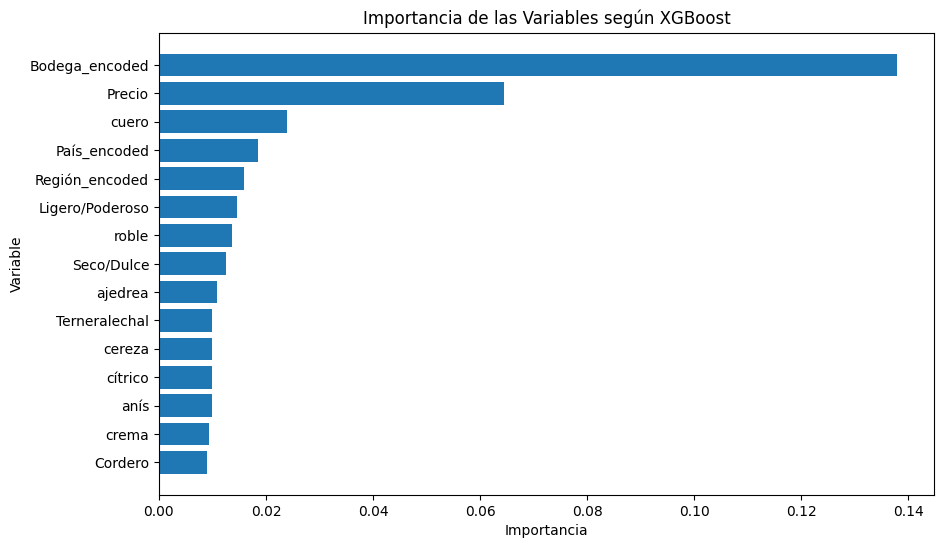

In [170]:
import matplotlib.pyplot as plt

# Extraer la importancia de las características
feature_importance = xgb_model.feature_importances_

# Crear un DataFrame con la importancia de cada variable
df_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
df_importance = df_importance.sort_values(by='Importance', ascending=False)

# Mostrar las variables más importantes
display(df_importance[:30])

# Graficar la importancia de las variables
plt.figure(figsize=(10,6))
plt.barh(df_importance['Feature'][:15], df_importance['Importance'][:15])
plt.gca().invert_yaxis()  # Invertir eje Y para mostrar las más importantes arriba
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.title("Importancia de las Variables según XGBoost")
plt.show()

In [171]:
top_features = df_importance['Feature'][0:9].tolist()  # Obtener los nombres de las 20 variables más importantes
X_train_selected = X_train_scaled[top_features]
X_test_selected = X_test_scaled[top_features]

In [172]:
top_features

['Bodega_encoded',
 'Precio',
 'cuero',
 'País_encoded',
 'Región_encoded',
 'Ligero/Poderoso',
 'roble',
 'Seco/Dulce',
 'ajedrea']

In [173]:
y_train.shape

(16124,)

In [177]:
model_forest = RandomForestRegressor(random_state = 42)
model_forest.fit(X_train_sel, y_train)

y_test_pred = model_forest.predict(X_test_sel)
y_train_pred = model_forest.predict(X_train_sel)


In [178]:
metrics = {
    "MAE": [mean_absolute_error(y_train, y_train_pred), mean_absolute_error(y_test, y_test_pred)],
    "RMSE": [(mean_squared_error(y_train, y_train_pred) ** 0.5), (mean_squared_error(y_test, y_test_pred) ** 0.5)],
    "R²": [r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)]
}

df_metrics = pd.DataFrame(metrics, index=["Train", "Test"])

display(df_metrics)

,MAE,RMSE,R²
Train,0.036554,0.052084,0.968304
Test,0.145820,0.194420,0.559035


In [179]:

from sklearn.model_selection import RandomizedSearchCV


# Definir espacio de búsqueda de hiperparámetros
hyperparams = {
    "n_estimators": [50, 100, 200, 300],  # Probar un número reducido de estimadores
    "max_depth": [None, 10, 20, 30],  # Niveles de profundidad
    "min_samples_split": [2, 5, 10],  # Mínimo número de muestras para dividir
    "min_samples_leaf": [1, 2, 4],  # Mínimo número de muestras en la hoja
    "max_features": ["sqrt", "log2"],  # Cuántas características se consideran en cada división
}

# Crear el RandomizedSearchCV
random_search = RandomizedSearchCV(
    model_forest,  # Tu modelo base ya creado
    param_distributions=hyperparams,
    n_iter=20,  # Número de combinaciones a probar
    scoring="r2",  # Métrica de regresión
    cv=5,  # Validación cruzada con 5 particiones
    n_jobs=-1,  # Usar todos los núcleos disponibles
    verbose=1,
    random_state=42
)

# Ajustar el modelo con los datos de entrenamiento
random_search.fit(X_train_sel, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", random_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejores hiperparámetros: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 20}


Mejores hiperparámetros: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}

In [180]:
# Extraer el modelo con los mejores hiperparámetros encontrados por RandomizedSearchCV
model_forest_2 = RandomForestRegressor(random_state = 42,n_estimators=200,min_samples_split=5,min_samples_leaf=4,max_features='log2',max_depth=None)
model_forest_2.fit(X_train_sel, y_train)

y_test_pred = model_forest_2.predict(X_test_sel)
y_train_pred = model_forest_2.predict(X_train_sel)

In [181]:
metrics = {
    "MAE": [mean_absolute_error(y_train, y_train_pred), mean_absolute_error(y_test, y_test_pred)],
    "RMSE": [(mean_squared_error(y_train, y_train_pred) ** 0.5), (mean_squared_error(y_test, y_test_pred) ** 0.5)],
    "R²": [r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)]
}

df_metrics = pd.DataFrame(metrics, index=["Train", "Test"])

display(df_metrics)

,MAE,RMSE,R²
Train,0.073138,0.102537,0.877154
Test,0.144950,0.192253,0.568810
